In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (8, 6), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 8, 6

In [3]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

# Part 1. Preliminary data analysis

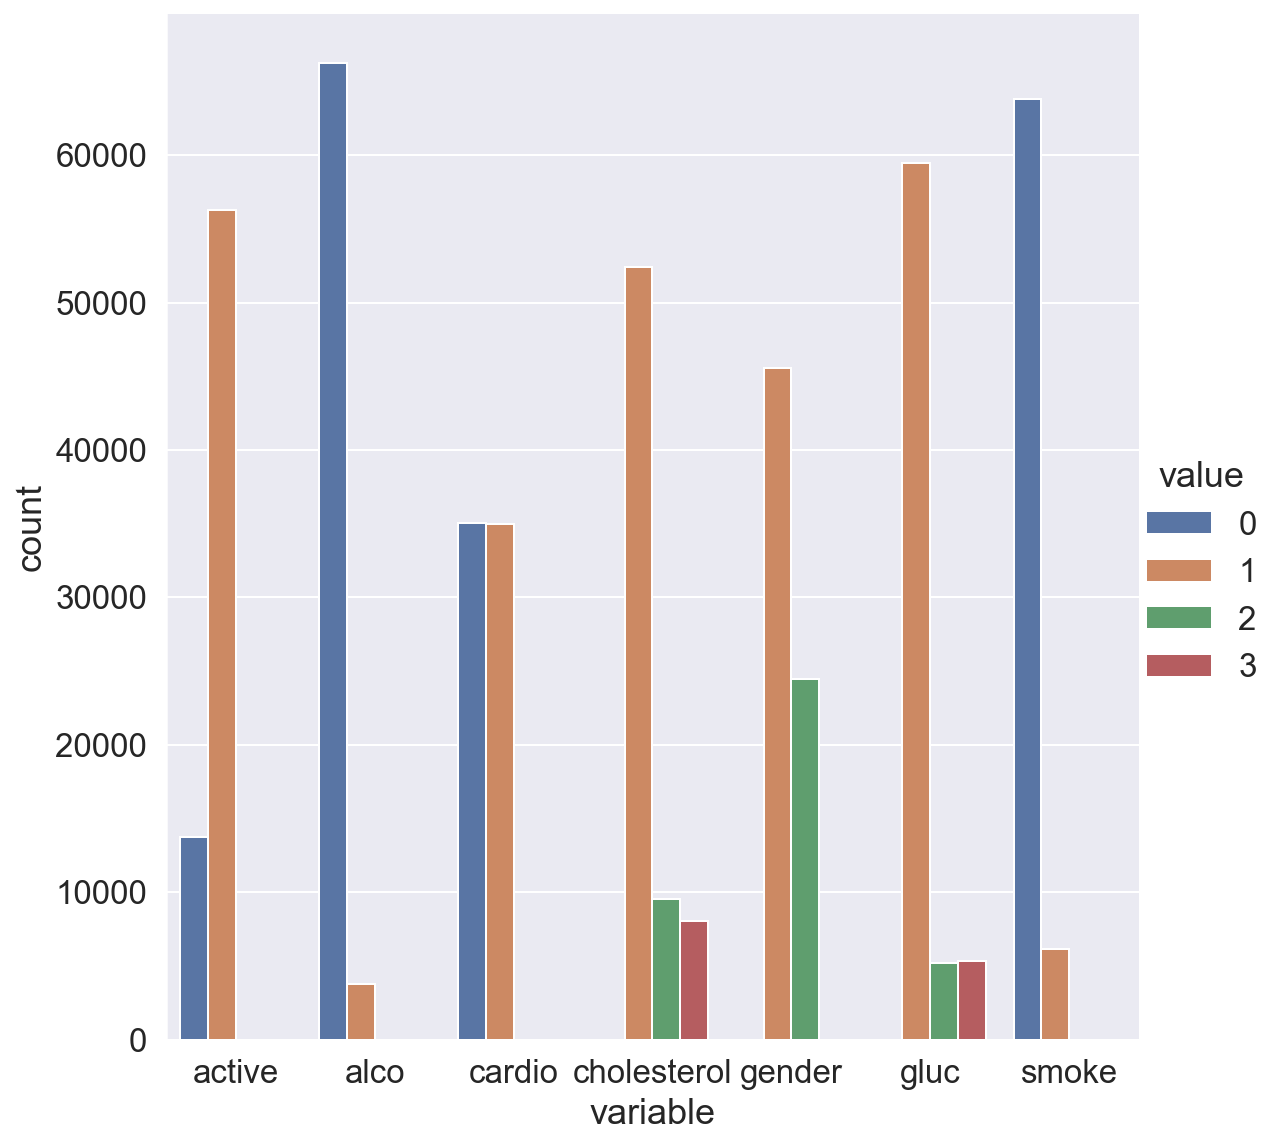

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", size=8
);

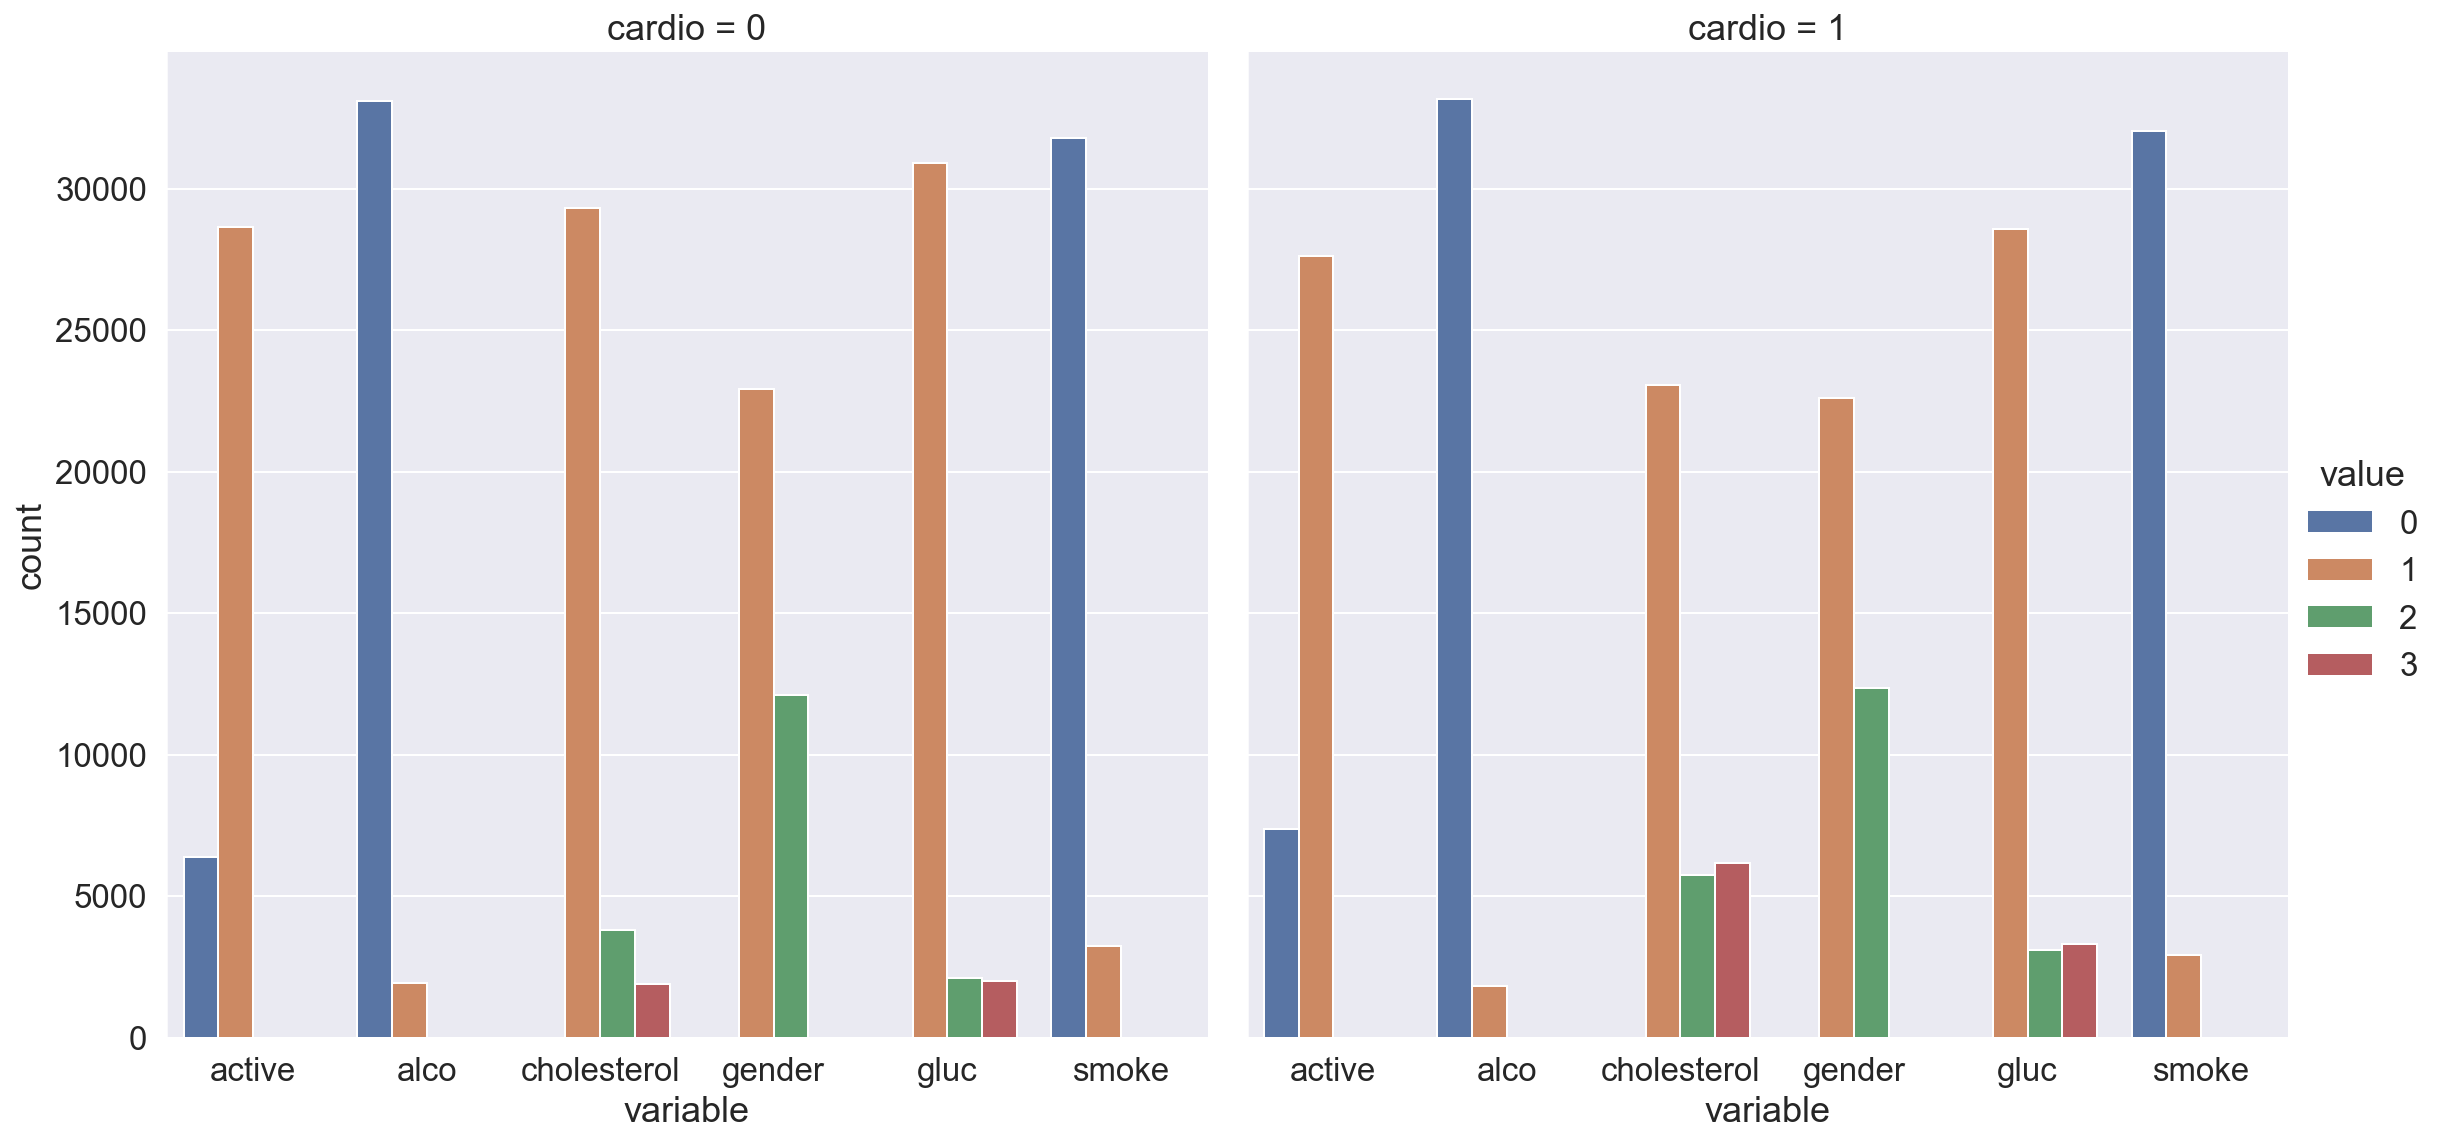

In [6]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    size=8
);

In [7]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.**

In [8]:
df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [9]:
df.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [10]:
## gender 1 - women; gender 2 - men

**Question 1.2. (1 point). Who more often report consuming alcohol – men or women?**

In [11]:
df.groupby('gender')['alco'].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

In [12]:
#men

**Question 1.3. (1 point). What’s the rounded difference between the percentages of smokers among men and women?**

In [13]:
sw = df[(df['smoke'] == 1) & (df['gender'] == 1)].shape[0] / df[df['gender'] == 1].shape[0] #women
print(sw)

0.017856358444981332


In [14]:
sm = df[(df['smoke'] == 1) & (df['gender'] == 2)].shape[0] / df[df['gender'] == 2].shape[0] #men
print(sm)

0.21888026154474868


In [15]:
round((sm - sw) * 100)

20

**Question 1.4. (1 point). What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.**

In [16]:
round((df[df['smoke'] == 0]['age'].median()-\
      df[df['smoke'] == 1]['age'].median())/365*12)

20

## 1.2. Risk maps

**Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive. Cholesterol level categories differ between the figure and our dataset.**

In [17]:
df['age_years'] = (df['age'] / 365).round().astype('int')

In [18]:
df['age_years']

0        50
1        55
2        52
3        48
4        48
         ..
69995    53
69996    62
69997    52
69998    61
69999    56
Name: age_years, Length: 70000, dtype: int64

In [19]:
men_smokers = df[(df['gender'] == 2)&\
                (df['smoke'] == 1)&\
                (df['age_years'] >= 60)&\
                (df['age_years'] <= 64)]

In [20]:
men_smokers[(men_smokers['cholesterol'] == 1) & (men_smokers['ap_hi'] < 120)]['cardio'].mean()

0.2564102564102564

In [21]:
men_smokers[(men_smokers['cholesterol'] == 1) &\
            (men_smokers['ap_hi'] >= 160)&\
           (men_smokers['ap_hi'] < 180)]['cardio'].mean()

0.8913043478260869

## 1.3. Analyzing BMI

**Create a new feature – BMI (Body Mass Index). To do this, divide weight in kilograms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.**

**Choose the correct statements:**

1) Median BMI in the sample is within boundaries of normal values. **No**

2) Women’s BMI is on average higher then men’s. **Yes**

3) Healthy people have higher median BMI than ill people. **No**

4) In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women **Yes**

In [22]:
df['BMI'] = df['weight'] / (df['height'] / 100)**2

In [23]:
df['BMI'].median()

26.374068120774975

In [24]:
df.groupby('gender')['BMI'].mean()

gender
1    27.987583
2    26.754442
Name: BMI, dtype: float64

In [25]:
df.groupby(['gender','cardio','alco'])['BMI'].mean()

gender  cardio  alco
1       0       0       26.845407
                1       28.671457
        1       0       29.052771
                1       30.812347
2       0       0       25.872638
                1       26.097220
        1       0       27.522450
                1       28.226569
Name: BMI, dtype: float64

## 1.4. Cleaning data

**Filter out the following patient segments (we consider these as erroneous data)**

diastolic pressure is higher than systolic

height is strictly less than 2.5 percentile 

height is strictly more than 97.5 percentile

weight is strictly less than 2.5 percentile

weight is strictly more than 97.5 percentile



**Question 1.7. (2 points). What percent of the original data (rounded) did we filter out in the previous step?**

In [26]:
idx =((df['ap_lo'] > df['ap_hi']) |
    (df['height'] < df['height'].quantile(0.025)) |
    (df['height'] > df['height'].quantile(0.975)) |
    (df['weight'] < df['weight'].quantile(0.025)) |
    (df['weight'] > df['weight'].quantile(0.975)))

In [27]:
problems = df[idx]

In [28]:
problems

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
14        23  14532       2     181    95.0    130     90            1     1   
15        24  16782       2     172   112.0    120     80            1     1   
23        33  23376       2     156    45.0    110     60            1     1   
44        59  19764       1     154    50.0    170     80            3     1   
62        81  20330       2     187   115.0    130     90            1     1   
...      ...    ...     ...     ...     ...    ...    ...          ...   ...   
69975  99963  21264       2     182   100.0    120     80            1     1   
69981  99972  17500       2     182   110.0    130     90            2     2   
69987  99979  18852       1     151    49.0    120     80            1     1   
69996  99995  22601       1     158   126.0    140     90            2     2   
69997  99996  19066       2     183   105.0    180     90            3     1   

       smoke  alco  active  cardio  age_years        BMI  
14         1     1       1       0         40  28.997894  
15         0     0       0       1         46  37.858302  
23         0     0       1       0         64  18.491124  
44         0     0       1       1         54  21.082813  
62         0     1       1       0         56  32.886271  
...      ...   ...     ...     ...        ...        ...  
69975      0     0       1       1         58  30.189591  
69981      0     0       1       1         48  33.208550  
69987      0     0       1       0         52  21.490286  
69996      0     0       1       1         62  50.472681  
69997      0     1       0       1         52  31.353579  

[6741 rows x 15 columns]

In [29]:
problems.shape[0]/df.shape[0] * 100

9.629999999999999

In [30]:
df_new = df[~idx]
df_new

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0  18393       2     168    62.0    110     80            1     1   
1          1  20228       1     156    85.0    140     90            3     1   
2          2  18857       1     165    64.0    130     70            3     1   
3          3  17623       2     169    82.0    150    100            1     1   
4          4  17474       1     156    56.0    100     60            1     1   
...      ...    ...     ...     ...     ...    ...    ...          ...   ...   
69993  99991  19699       1     172    70.0    130     90            1     1   
69994  99992  21074       1     165    80.0    150     80            1     1   
69995  99993  19240       2     168    76.0    120     80            1     1   
69998  99998  22431       1     163    72.0    135     80            1     2   
69999  99999  20540       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  age_years        BMI  
0          0     0       1       0         50  21.967120  
1          0     0       1       1         55  34.927679  
2          0     0       0       1         52  23.507805  
3          0     0       1       1         48  28.710479  
4          0     0       0       0         48  23.011177  
...      ...   ...     ...     ...        ...        ...  
69993      0     0       1       1         54  23.661439  
69994      0     0       1       1         58  29.384757  
69995      1     0       1       0         53  26.927438  
69998      0     0       0       1         61  27.099251  
69999      0     0       1       0         56  24.913495  

[63259 rows x 15 columns]

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

**Plot a correlation matrix using heatmap(). You can create the matrix using the standard pandas tools with the default parameters.**

**Question 2.1**. Which pair of features has the strongest Pearson’s correlation with the gender feature?

1) Cardio, Cholesterol

2) Height, Smoke **Yes**

3) Smoke, Alco

4) Height, Weight

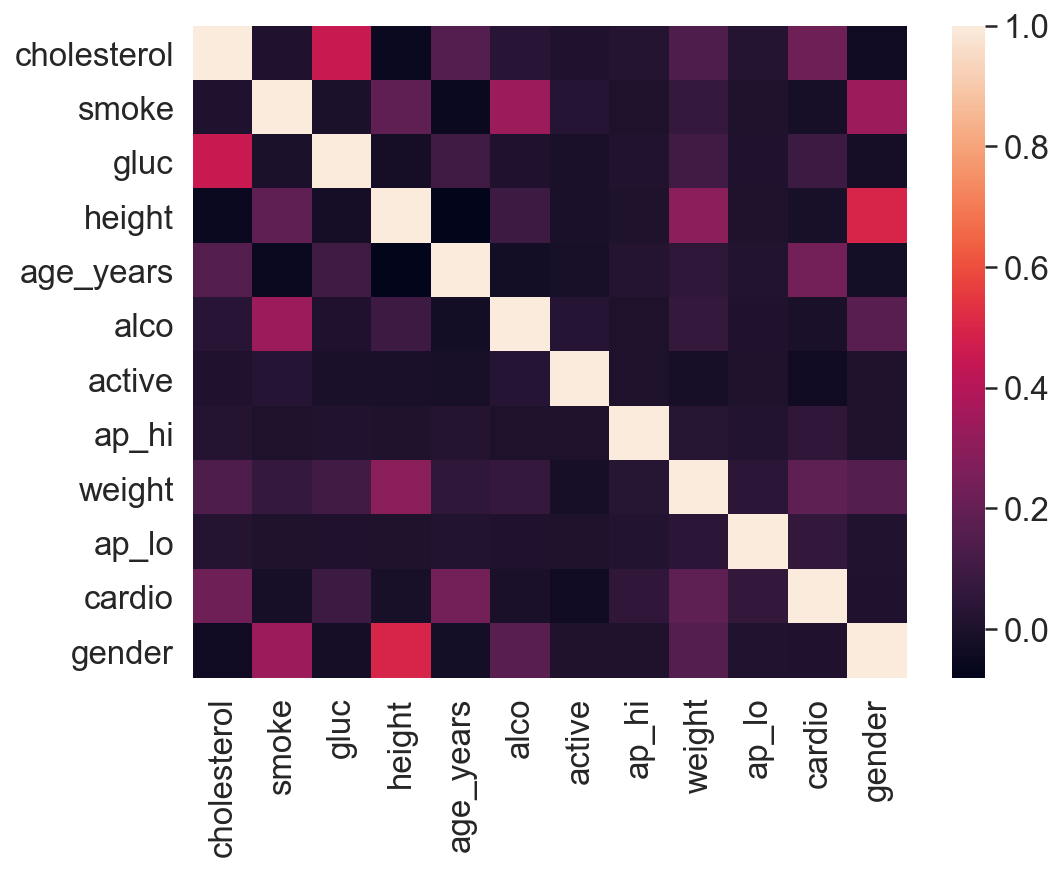

In [32]:
corr_col = list(set(df.columns) - set(['id','age','BMI']))

corr_matrix = df[corr_col].corr()
sns.heatmap(corr_matrix);

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values 1 and 2. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the gender feature.

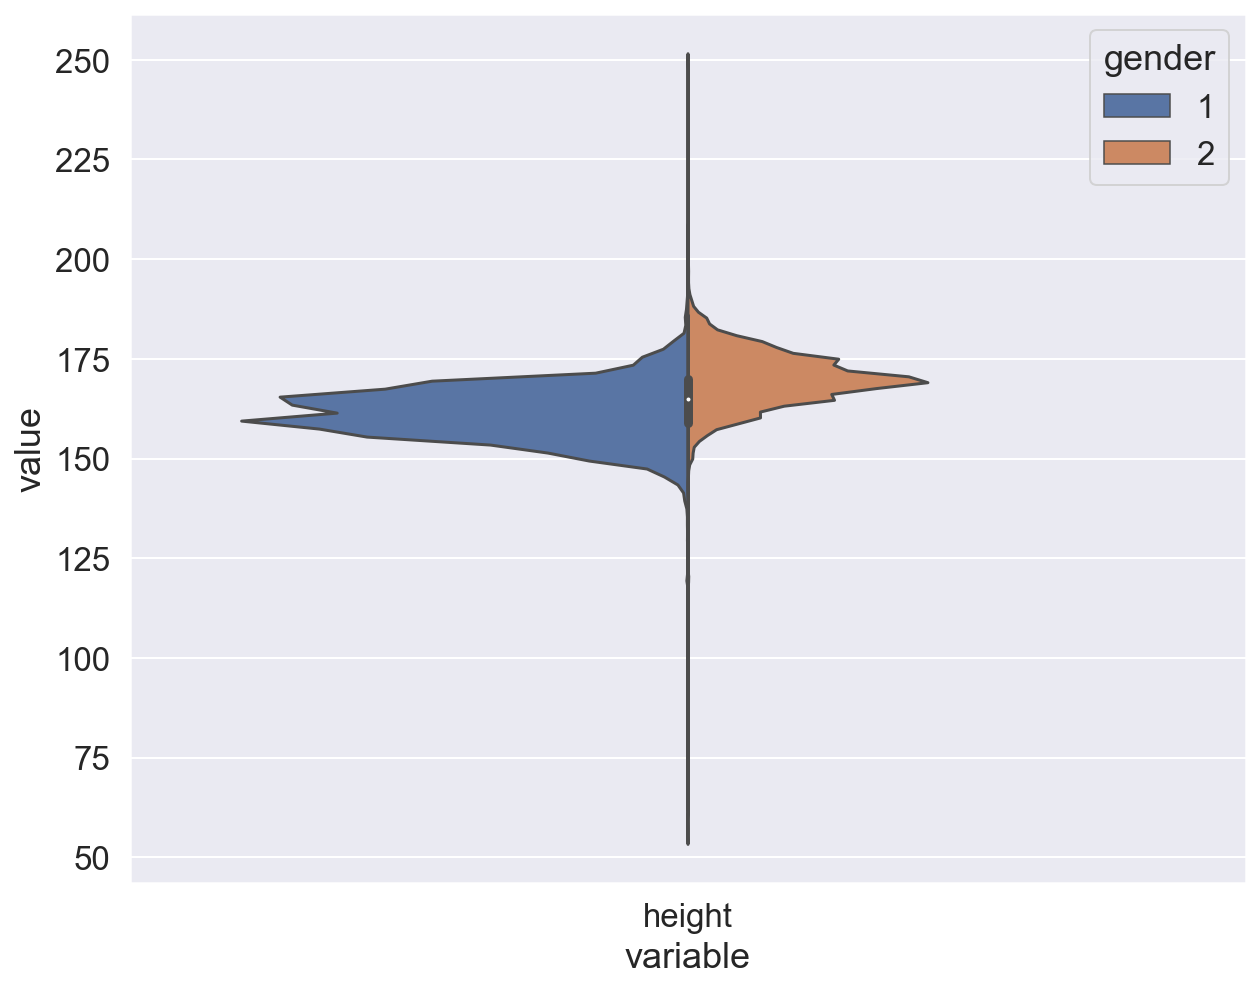

In [56]:
violin = pd.melt(df, value_vars='height', id_vars='gender')
plt.figure(figsize=(10, 8))
sns.violinplot(x='variable', y='value', hue='gender', data=violin, split=True, scale='count')
plt.show()

## 2.3. Rank correlation

**Calculate and plot a correlation matrix using the Spearman’s rank correlation coefficient.**

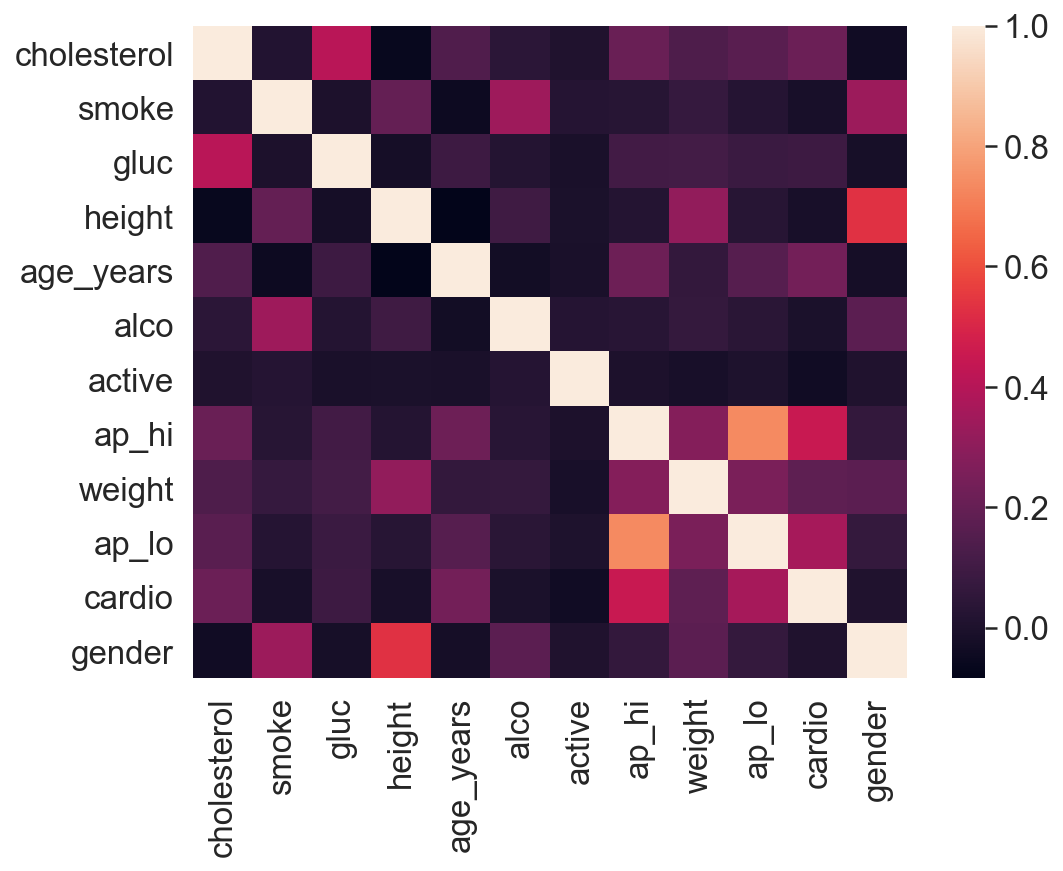

In [53]:
corr_matrix = df[corr_col].corr(method='spearman')
sns.heatmap(corr_matrix);

**Question 2.2.** Which pair of features has the strongest Spearman rank correlation?

1) Height, Weight

2) Age, Weight

3) Cholesterol, Gluc

4) Cardio, Cholesterol

5) Ap_hi, Ap_lo **Yes**

6) Smoke, Alco

**Question 2.3.** Why do these features have strong rank correlation?

1) Inaccuracies in the data (data acquisition errors).

2) Relation is wrong, these features should not be related. 

3) Nature of the data. **Yes**

## 2.4. Age

Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each cardio class of that age.

In [57]:
df

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0  18393       2     168    62.0    110     80            1     1   
1          1  20228       1     156    85.0    140     90            3     1   
2          2  18857       1     165    64.0    130     70            3     1   
3          3  17623       2     169    82.0    150    100            1     1   
4          4  17474       1     156    56.0    100     60            1     1   
...      ...    ...     ...     ...     ...    ...    ...          ...   ...   
69995  99993  19240       2     168    76.0    120     80            1     1   
69996  99995  22601       1     158   126.0    140     90            2     2   
69997  99996  19066       2     183   105.0    180     90            3     1   
69998  99998  22431       1     163    72.0    135     80            1     2   
69999  99999  20540       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  age_years        BMI  
0          0     0       1       0         50  21.967120  
1          0     0       1       1         55  34.927679  
2          0     0       0       1         52  23.507805  
3          0     0       1       1         48  28.710479  
4          0     0       0       0         48  23.011177  
...      ...   ...     ...     ...        ...        ...  
69995      1     0       1       0         53  26.927438  
69996      0     0       1       1         62  50.472681  
69997      0     1       0       1         52  31.353579  
69998      0     0       0       1         61  27.099251  
69999      0     0       1       0         56  24.913495  

[70000 rows x 15 columns]

In [66]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age_years', hue = 'cardio', data=df);

**Question 2.4.** What is the smallest age at which the number of people with CVD outnumbers the number of people without CVD?

1) 44

2) 55 **Yes**

3) 64

4) 70